Text -> turn into numbers -> build a model -> train the model to find patterns -> use patterns (make predictions)

### Check for GPU

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e3f95275-6c40-b002-5e33-5a5ccc23210c)


### Get helper functions

In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-12-27 01:10:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-27 01:10:17 (104 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

### Download a text dataset

Let's start by download a text dataset. We'll be using the Real or Not? dataset from Kaggle which contains text-based Tweets about natural disasters.

The Real Tweets are actually about disasters, for example:

Jetstar and Virgin forced to cancel Bali flights again because of ash from Mount Raung volcano

The Not Real Tweets are Tweets not about disasters (they can be on anything), for example:

'Education is the most powerful weapon which you can use to change the world.' Nelson #Mandela #quote

In [4]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2022-12-27 01:11:27--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2022-12-27 01:11:27 (157 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]




Unzipping nlp_getting_started.zip gives the following 3 .csv files:

1. sample_submission.csv - an example of the file you'd submit to the Kaggle competition of your model's predictions.
2. train.csv - training samples of real and not real diaster Tweets.
3. test.csv - testing samples of real and not real diaster Tweets.

### Visualizing a text dataset

Right now, our text data samples are in the form of .csv files. For an easy way to make them visual, let's turn them into pandas DataFrame's.

📖 Reading: You might come across text datasets in many different formats. Aside from CSV files (what we're working with), you'll probably encounter .txt files and .json files too. For working with these type of files, I'd recommend reading the two following articles by RealPython:

1. How to Read and Write Files in Python : https://realpython.com/read-write-files-python/
2. Working with JSON Data in Python : https://realpython.com/python-json/

In [5]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0



Notice how the training data has a "target" column.

We're going to be writing code to find patterns (e.g. different combinations of words) in the "text" column of the training dataset to predict the value of the "target" column.

The test dataset doesn't have a "target" column.

Inputs (text column) -> Machine Learning Algorithm -> Outputs (target column)

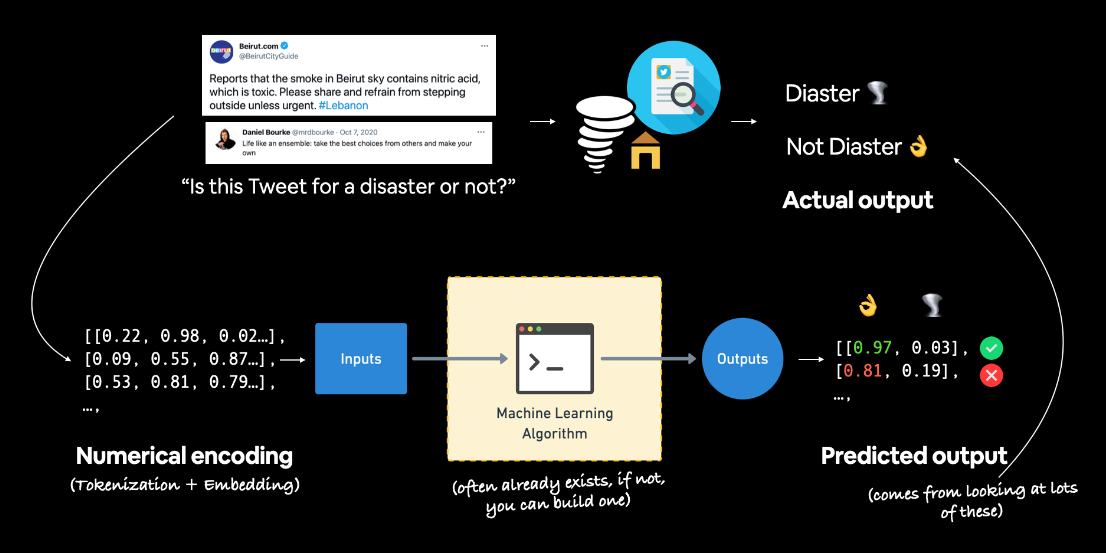

In [7]:
# The test data doesn't have a target (that's what we'd try to predict)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64


Since we have two target values, we're dealing with a binary classification problem.

It's fairly balanced too, about 60% negative class (target = 0) and 40% positive class (target = 1).

Where,

1 = a real disaster Tweet

0 = not a real disaster Tweet

In [9]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [10]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
@CVinch_WAOW thank you! Drove by the mayhem. How scary! -Stacy

---

Target: 1 (real disaster)
Text:
I will adamantly opposed to nuclear weapons.

---

Target: 1 (real disaster)
Text:
'Food crematoria' in Russia provoke outrage amid crisis famine memories
http://t.co/FelR5a1hBP

---

Target: 1 (real disaster)
Text:
The Latest: More homes razed by Northern California wildfire - http://t.co/BsGR67dyWY http://t.co/nDGgr6Xyqd

---

Target: 0 (not real disaster)
Text:
--thus making @FemaleGilgamesh's assault useless.
The spears collided with the dark force however did not penetrate.

Due to the dark --

---



#### Split data into training and validation sets

Since the test set has no labels and we need a way to evalaute our trained models, we'll split off some of the training data and create a validation set.

When our model trains (tries patterns in the Tweet samples), it'll only see data from the training set and we can see how it performs on unseen data using the validation set.

We'll convert our splits from pandas Series datatypes to lists of strings (for the text) and lists of ints (for the labels) for ease of use later.

To split our training dataset and create a validation dataset, we'll use Scikit-Learn's train_test_split() method and dedicate 10% of the training samples to the validation set.

In [11]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [12]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

### Converting text into numbers

In NLP, there are two main concepts for turning text into numbers:

Tokenization - A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:

1. Using word-level tokenization with the sentence "I love TensorFlow" might result in "I" being 0, "love" being 1 and "TensorFlow" being 2. In this case, every word in a sequence considered a single token.
2. Character-level tokenization, such as converting the letters A-Z to values 1-26. In this case, every character in a sequence considered a single token.
3. Sub-word tokenization is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple tokens.

Embeddings - An embedding is a representation of natural language which can be learned. Representation comes in the form of a feature vector. For example, the word "dance" could be represented by the 5-dimensional vector [-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings:

1. Create your own embedding - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as tf.keras.layers.Embedding) and an embedding representation will be learned during model training.
2. Reuse a pre-learned embedding - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.

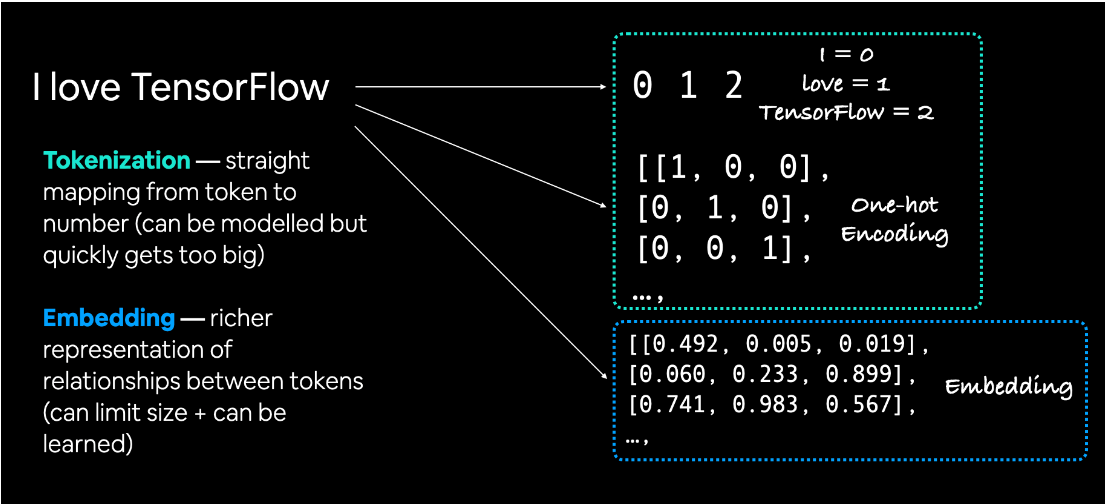

It depends on your problem. You could try character-level tokenization/embeddings and word-level tokenization/embeddings and see which perform best. You might even want to try stacking them (e.g. combining the outputs of your embedding layers using **tf.keras.layers.concatenate)**.

If you're looking for pre-trained word embeddings, **Word2vec** embeddings, **GloVe** embeddings and many of the options available on TensorFlow Hub are great places to start.

#### Text vectorization (tokenization)

We'll practice tokenzation (mapping our words to numbers) first.

To tokenize our words, we'll use the helpful preprocessing layer tf.keras.layers.experimental.preprocessing.TextVectorization.

The TextVectorization layer takes the following parameters:

1. max_tokens - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens.
2. standardize - Method for standardizing text. Default is "lower_and_strip_punctuation" which lowers text and removes all punctuation marks.
3. split - How to split text, default is "whitespace" which splits on spaces.
4. ngrams - How many words to contain per token split, for example, ngrams=2 splits tokens into continuous sequences of 2.
5. output_mode - How to output tokens, can be "int" (integer mapping), "binary" (one-hot encoding), "count" or "tf-idf". See documentation for more.
6. output_sequence_length - Length of tokenized sequence to output. For example, if output_sequence_length=150, all tokenized sequences will be 150 tokens long.
7. pad_to_max_tokens - Defaults to False, if True, the output feature axis will be padded to max_tokens even if the number of unique tokens in the vocabulary is less than max_tokens. Only valid in certain modes, see docs for more.

In [14]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Note: in TensorFlow 2.6+, you no longer need "layers.experimental.preprocessing"
# you can use: "tf.keras.layers.TextVectorization", see https://github.com/tensorflow/tensorflow/releases/tag/v2.6.0 for more

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

We've initialized a TextVectorization object with the default settings but let's customize it a little bit for our own use case.

In particular, let's set values for max_tokens and output_sequence_length.

For max_tokens (the number of words in the vocabulary), multiples of 10,000 (10,000, 20,000, 30,000) or the exact number of unique words in your text (e.g. 32,179) are common values.

For our use case, we'll use 10,000.

And for the output_sequence_length we'll use the average number of tokens per Tweet in the training set. But first, we'll need to find it.

In [15]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [16]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

To map our TextVectorization instance text_vectorizer to our data, we can call the adapt() method on it whilst passing it our training text.

In [17]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

Training data mapped! Let's try our text_vectorizer on a custom sentence (one similar to what you might see in the training data).

In [18]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

Wonderful, it seems we've got a way to turn our text into numbers (in this case, word-level tokenization). Notice the 0's at the end of the returned tensor, this is because we set output_sequence_length=15, meaning no matter the size of the sequence we pass to text_vectorizer, it always returns a sequence with a length of 15.

How about we try our text_vectorizer on a few random sentences?

In [19]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
And that's because on my planet it's the lone audience of the apocalypse!      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   7,  215,  152,   11,   13, 2347,   37,    2, 5195, 6163,    6,
           2,  409,    0,    0]])>

Finally, we can check the unique tokens in our vocabulary using the get_vocabulary() method.

In [20]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


#### Creating an Embedding using an Embedding Layer

We've got a way to map our text to numbers. How about we go a step further and turn those numbers into an embedding?

The powerful thing about an embedding is it can be learned during training. This means rather than just being static (e.g. 1 = I, 2 = love, 3 = TensorFlow), a word's numeric representation can be improved as a model goes through data samples.

We can see what an embedding of a word looks like by using the tf.keras.layers.Embedding layer.

The main parameters we're concerned about here are:

1. input_dim - The size of the vocabulary (e.g. len(text_vectorizer.get_vocabulary()).
2. output_dim - The size of the output embedding vector, for example, a value of 100 outputs a feature vector of size 100 for each word.
3. embeddings_initializer - How to initialize the embeddings matrix, default is "uniform" which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
4. input_length - Length of sequences being passed to embedding layer.

In [21]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding


Excellent, notice how embedding is a TensoFlow layer? This is important because we can use it as part of a model, meaning its parameters (word representations) can be updated and improved as the model learns.

In [22]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
When you're in deep sleep and then you dream you're bout to fall off a cliff then wake up while struggling to keep a balance      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03493195,  0.00647281, -0.00628376, ...,  0.03327657,
          0.03445746,  0.02336425],
        [ 0.02951511, -0.04593171, -0.02894578, ...,  0.03564817,
         -0.01119394, -0.01152975],
        [-0.04364428,  0.02437404, -0.03696011, ..., -0.04763393,
          0.02931459,  0.0068561 ],
        ...,
        [ 0.0029236 ,  0.04938162,  0.04758375, ...,  0.02993738,
          0.00653443,  0.03262198],
        [ 0.00436133,  0.00832624, -0.03833674, ..., -0.03509976,
         -0.0198932 ,  0.00739045],
        [-0.04284013, -0.01489798, -0.0159496 , ..., -0.01166106,
          0.03061062,  0.01972148]]], dtype=float32)>


Each token in the sentence gets turned into a length 128 feature vector.

In [23]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.03493195,  0.00647281, -0.00628376,  0.01005496,  0.04936887,
       -0.00559781, -0.03117973, -0.0382193 ,  0.01585368,  0.0246987 ,
        0.02640421,  0.02499007,  0.0136514 , -0.03144592,  0.04485254,
       -0.01263661, -0.00016946,  0.02885785, -0.00686482,  0.04157788,
       -0.03018022, -0.00350765, -0.04854878, -0.04820365,  0.02913711,
       -0.0091291 ,  0.00031001,  0.04693094, -0.04545189,  0.00767597,
       -0.03688604,  0.00360719, -0.0126606 ,  0.04264385, -0.01742848,
        0.03991449, -0.04341568,  0.03905055, -0.0324254 ,  0.03230431,
       -0.0205789 , -0.04173296,  0.00169666, -0.02650962,  0.04648874,
        0.03207911,  0.02619224,  0.04265671,  0.01069625,  0.04664482,
        0.04694431, -0.03336285, -0.0211965 ,  0.04417011,  0.0393195 ,
       -0.03612698, -0.04469332, -0.02127515, -0.02182194,  0.02654419,
       -0.02255355, -0.03496559, -0.01665587,  0.01279463,  0.00375772,
        0.034198

### Modelling a text dataset

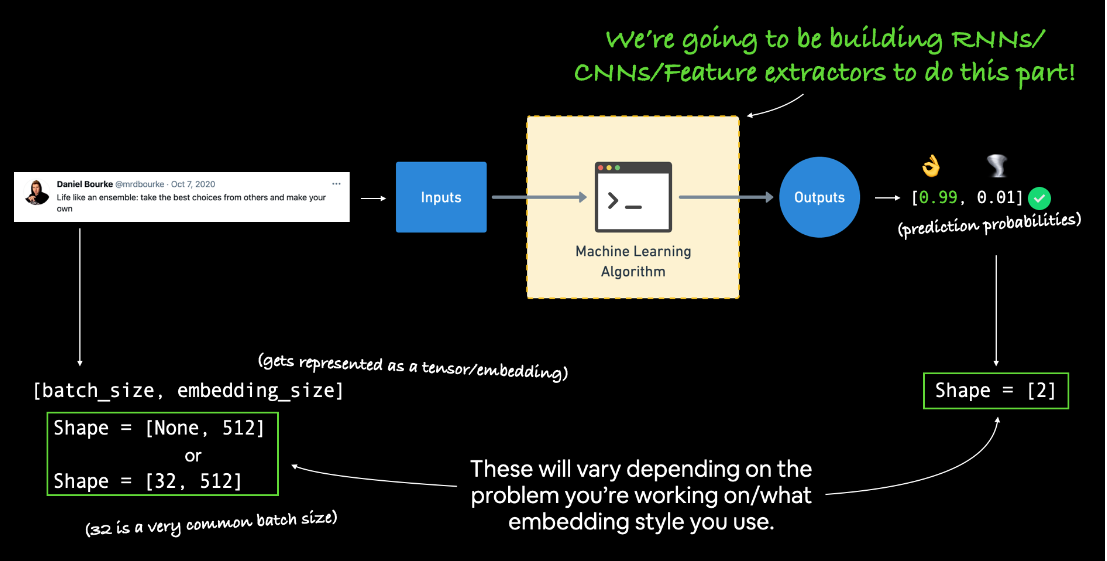

More specifically, we'll be building the following:

Model 0: Naive Bayes (baseline)

Model 1: Feed-forward neural network (dense model)

Model 2: LSTM model

Model 3: GRU model

Model 4: Bidirectional-LSTM model

Model 5: 1D Convolutional Neural Network

Model 6: TensorFlow Hub Pretrained Feature Extractor

Model 7: Same as model 6 with 10% of training data

Model 0 is the simplest to acquire a baseline which we'll expect each other of the other deeper models to beat.

Each experiment will go through the following steps:

1. Construct the model
2. Train the model
3. Make predictions with the model
4. Track prediction evaluation metrics for later comparison

#### Model 0: Getting a baseline

To create our baseline, we'll create a Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the Multinomial Naive Bayes algorithm. This was chosen via referring to the Scikit-Learn machine learning map.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [26]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

#### Creating an evaluation function for our model experiments

We could evaluate these as they are but since we're going to be evaluating several models in the same way going forward, let's create a helper function which takes an array of predictions and ground truth labels and computes the following:

Accuracy

Precision

Recall

F1-score

In [27]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [28]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

#### Model 1: A simple dense model

The first "deep" model we're going to build is a single layer dense model. In fact, it's barely going to have a single layer.

It'll take our text and labels as input, tokenize the text, create an embedding, find the average of the embedding (using Global Average Pooling) and then pass the average through a fully connected layer with one output unit and a sigmoid activation function.

If the previous sentence sounds like a mouthful, it'll make sense when we code it out (remember, if in doubt, code it out).

And since we're going to be building a number of TensorFlow deep learning models, we'll import our create_tensorboard_callback() function from helper_functions.py to keep track of the results of each.

In [29]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [30]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model


Looking good. Our model takes a 1-dimensional string as input (in our case, a Tweet), it then tokenizes the string using text_vectorizer and creates an embedding using embedding.

We then (optionally) pool the outputs of the embedding layer to reduce the dimensionality of the tensor we pass to the output layer.

🛠 Exercise: Try building model_1 with and without a GlobalAveragePooling1D() layer after the embedding layer. What happens? Why do you think this is?

Finally, we pass the output of the pooling layer to a dense layer with sigmoid activation (we use sigmoid since our problem is binary classification).

Before we can fit our model to the data, we've got to compile it. Since we're working with binary classification, we'll use "binary_crossentropy" as our loss function and the Adam optimizer.

In [31]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [32]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [33]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20221227-013250
Epoch 1/5
215/215 [==============================] - 4s 5ms/step - loss: 0.6094 - accuracy: 0.6916 - val_loss: 0.5357 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4410 - accuracy: 0.8189 - val_loss: 0.4691 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3463 - accuracy: 0.8605 - val_loss: 0.4590 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2848 - accuracy: 0.8923 - val_loss: 0.4641 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2380 - accuracy: 0.9118 - val_loss: 0.4767 - val_accuracy: 0.7874


In [34]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4767 - accuracy: 0.7874


[0.4766846001148224, 0.787401556968689]

In [35]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.00073164,  0.01504801, -0.03425454, ..., -0.04403539,
         -0.01042281,  0.01876436],
        [ 0.04135863, -0.03945083, -0.03811942, ...,  0.00464736,
          0.03163554,  0.02928298],
        [ 0.00684031,  0.05363133, -0.00241555, ..., -0.07082176,
         -0.04750703,  0.01448254],
        ...,
        [-0.03301444, -0.0052493 , -0.04209725, ...,  0.02028764,
          0.00308807,  0.02215792],
        [ 0.00692343,  0.05942352, -0.01975194, ..., -0.06199061,
         -0.01018393,  0.03510419],
        [-0.03723461,  0.06267188, -0.07451147, ..., -0.02367217,
         -0.0864333 ,  0.01742155]], dtype=float32)>]

In [36]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [ ]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs \
#   --name "First deep model on text data" \
#   --description "Trying a dense model with an embedding layer" \
#   --one_shot # exits the uploader when upload has finished

In [ ]:
# If you need to remove previous experiments, you can do so using the following command
# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

In [37]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 [==============================] - 0s 3ms/step


array([[0.40488204],
       [0.7443312 ],
       [0.997895  ],
       [0.10889999],
       [0.11143529],
       [0.93556094],
       [0.91345936],
       [0.9925345 ],
       [0.97156817],
       [0.2657034 ]], dtype=float32)

In [38]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

Now we've got our model's predictions in the form of classes, we can use our calculate_results() function to compare them to the ground truth validation labels.

In [39]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497,
 'f1': 0.7846966492209201}

In [40]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])


Since we'll be doing this kind of comparison (baseline compared to new model) quite a few times, let's create a function to help us out.

In [41]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.74, Difference: -0.52
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


### Visualizing learned embeddings

Our first model (model_1) contained an embedding layer (embedding) which learned a way of representing words as feature vectors by passing over the training data.

Hearing this for the first few times may sound confusing.

So to further help understand what a text embedding is, let's visualize the embedding our model learned.

To do so, let's remind ourselves of the words in our vocabulary.

In [42]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [43]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [44]:
# Get the weight matrix of embedding layer 
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 128)



Now we've got these two objects, we can use the Embedding Projector tool to visualize our embedding.

To use the Embedding Projector tool, we need two files:

The embedding vectors (same as embedding weights).

The meta data of the embedding vectors (the words they represent - our vocabulary).

Right now, we've got of these files as Python objects. To download them to file, we're going to use the code example available on the TensorFlow word embeddings tutorial page.

In [ ]:
# # Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
# import io

# # Create output writers
# out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
# out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# # Write embedding vectors and words to file
# for num, word in enumerate(words_in_vocab):
#   if num == 0: 
#      continue # skip padding token
#   vec = embed_weights[num]
#   out_m.write(word + "\n") # write words to file
#   out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
# out_v.close()
# out_m.close()

# # Download files locally to upload to Embedding Projector
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download("embedding_vectors.tsv")
#   files.download("embedding_metadata.tsv")


Once you've downloaded the embedding vectors and metadata, you can visualize them using Embedding Vector tool:

1. Go to http://projector.tensorflow.org/
2. Click on "Load data"
3. Upload the two files you downloaded (embedding_vectors.tsv and embedding_metadata.tsv)
4. Explore
5. Optional: You can share the data you've created by clicking "Publish"
What do you find?

Are words with similar meanings close together?

Remember, they might not be. The embeddings we downloaded are how our model interprets words, not necessarily how we interpret them.

Also, since the embedding has been learned purely from Tweets, it may contain some strange values as Tweets are a very unique style of natural language.

🤔 Question: Do you have to visualize embeddings every time?

No. Although helpful for gaining an intuition of what natural language embeddings are, it's not completely necessary. Especially as the dimensions of your vocabulary and embeddings grow, trying to comprehend them would become an increasingly difficult task.

### Recurrent Neural Networks (RNN's)

For our next series of modelling experiments we're going to be using a special kind of neural network called a Recurrent Neural Network (RNN).

The premise of an RNN is simple: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (X) and compute an output (y) based on all previous inputs.

This concept is especially helpful when dealing with sequences such as passages of natural language text (such as our Tweets).

For example, when you read this sentence, you take into context the previous words when deciphering the meaning of the current word dog.

See what happened there?

I put the word "dog" at the end which is a valid word but it doesn't make sense in the context of the rest of the sentence.

When an RNN looks at a sequence of text (already in numerical form), the patterns it learns are continually updated based on the order of the sequence.

For a simple example, take two sentences:

Massive earthquake last week, no?

No massive earthquake last week.

Both contain exactly the same words but have different meaning. The order of the words determines the meaning (one could argue punctuation marks also dictate the meaning but for simplicity sake, let's stay focused on the words).

Recurrent neural networks can be used for a number of sequence-based problems:

1. One to one: one input, one output, such as image classification.
2. One to many: one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
3. Many to one: many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).
4. Many to many: many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).

When you come across RNN's in the wild, you'll most likely come across variants of the following:

1. Long short-term memory cells (LSTMs).
2. Gated recurrent units (GRUs).
3. Bidirectional RNN's (passes forward and backward along a sequence, left to right and right to left).


#### Model 2: LSTM

We're going to start with an LSTM-powered RNN.

To harness the power of the LSTM cell (LSTM cell and LSTM layer are often used interchangably) in TensorFlow, we'll use **tensorflow.keras.layers.LSTM()**.

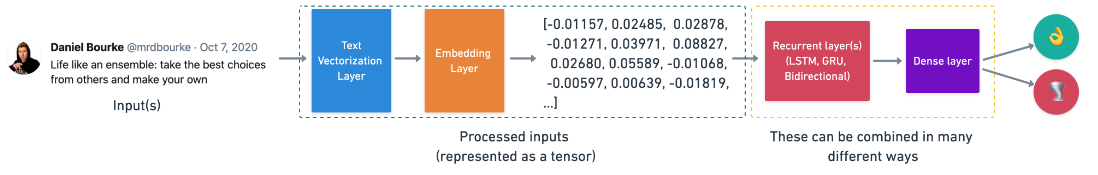

Our model is going to take on a very similar structure to model_1:
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

The main difference will be that we're going to add an LSTM layer between our embedding and output.

And to make sure we're not getting reusing trained embeddings (this would involve data leakage between models, leading to an uneven comparison later on), we'll create another embedding layer (model_2_embedding) for our model. The text_vectorizer layer can be reused since it doesn't get updated during training.

In [45]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [46]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [47]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [48]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20221227-014144
Epoch 1/5
215/215 [==============================] - 6s 8ms/step - loss: 0.5100 - accuracy: 0.7416 - val_loss: 0.4566 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3176 - accuracy: 0.8717 - val_loss: 0.5138 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2201 - accuracy: 0.9152 - val_loss: 0.5858 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1556 - accuracy: 0.9428 - val_loss: 0.6041 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1076 - accuracy: 0.9594 - val_loss: 0.8746 - val_accuracy: 0.7507


In [49]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

24/24 [==============================] - 0s 3ms/step


((762, 1), array([[0.007126  ],
        [0.78736776],
        [0.9996376 ],
        [0.05679179],
        [0.00258219],
        [0.9996238 ],
        [0.9217022 ],
        [0.9997993 ],
        [0.9994954 ],
        [0.6645741 ]], dtype=float32))

In [50]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [51]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.06561679790026,
 'precision': 0.7510077975908164,
 'recall': 0.7506561679790026,
 'f1': 0.7489268622514025}

In [52]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 75.07, Difference: -4.20
Baseline precision: 0.81, New precision: 0.75, Difference: -0.06
Baseline recall: 0.79, New recall: 0.75, Difference: -0.04
Baseline f1: 0.79, New f1: 0.75, Difference: -0.04


#### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

To use the GRU cell in TensorFlow, we can call the **tensorflow.keras.layers.GRU()** class.

The architecture of the GRU-powered model will follow the same structure we've been using:

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

In [53]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [54]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [55]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________


Notice the difference in number of trainable parameters between model_2 (LSTM) and model_3 (GRU). The difference comes from the LSTM cell having more trainable parameters than the GRU cell.

In [56]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20221227-014338
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.5242 - accuracy: 0.7314 - val_loss: 0.4553 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3195 - accuracy: 0.8694 - val_loss: 0.4937 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2197 - accuracy: 0.9181 - val_loss: 0.5607 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1599 - accuracy: 0.9441 - val_loss: 0.6220 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1221 - accuracy: 0.9584 - val_loss: 0.6205 - val_accuracy: 0.7677


In [57]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1), array([[0.33325267],
        [0.87741184],
        [0.9980252 ],
        [0.11561754],
        [0.01235959],
        [0.9925639 ],
        [0.6214263 ],
        [0.99813336],
        [0.9982377 ],
        [0.5018107 ]], dtype=float32))

In [58]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [59]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.77165354330708,
 'precision': 0.7675450859410361,
 'recall': 0.7677165354330708,
 'f1': 0.7667932666650168}

In [60]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 76.77, Difference: -2.49
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


#### Model 4: Bidirectonal RNN mode

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

Intuitively, this can be thought of as if you were reading a sentence for the first time in the normal fashion (left to right) but for some reason it didn't make sense so you traverse back through the words and go back over them again (right to left).

In practice, many sequence models often see and improvement in performance when using bidirectional RNN's.

However, this improvement in performance often comes at the cost of longer training times and increased model parameters (since the model goes left to right and right to left, the number of trainable parameters doubles).

Once again, TensorFlow helps us out by providing the **tensorflow.keras.layers.Bidirectional** class. We can use the Bidirectional class to wrap our existing RNNs, instantly making them bidirectional.

In [61]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [62]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [63]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [64]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20221227-014515
Epoch 1/5
215/215 [==============================] - 5s 12ms/step - loss: 0.5093 - accuracy: 0.7481 - val_loss: 0.4606 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3135 - accuracy: 0.8708 - val_loss: 0.5144 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2150 - accuracy: 0.9178 - val_loss: 0.5626 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1523 - accuracy: 0.9469 - val_loss: 0.6365 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1083 - accuracy: 0.9639 - val_loss: 0.6509 - val_accuracy: 0.7664


In [65]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


array([[0.04000054],
       [0.827929  ],
       [0.99842227],
       [0.13531096],
       [0.00311337],
       [0.99220747],
       [0.9552836 ],
       [0.99945647],
       [0.99898285],
       [0.28141677]], dtype=float32)

In [66]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [67]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.64041994750657,
 'precision': 0.7665895370389821,
 'recall': 0.7664041994750657,
 'f1': 0.7651213533864446}

In [68]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.64, Difference: -2.62
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.03
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


### Convolutional Neural Networks for Text

The main difference between using CNNs for images and sequences is the shape of the data. Images come in 2-dimensions (height x width) where as sequences are often 1-dimensional (a string of text).

So to use CNNs with sequences, we use a 1-dimensional convolution instead of a 2-dimensional convolution.

A typical CNN architecture for sequences will look like the following:

Inputs (text) -> Tokenization -> Embedding -> Layers -> Outputs (class probabilities)

The difference again is in the layers component. Instead of using an LSTM or GRU cell, we're going to use a **tensorflow.keras.layers.Conv1D()** layer followed by a **tensorflow.keras.layers.GlobablMaxPool1D()** layer.

#### Model 5: Conv1D

Before we build a full 1-dimensional CNN model, let's see a 1-dimensional convolutional layer (also called a temporal convolution) in action.

We'll first create an embedding of a sample of text and experiment passing it through a Conv1D() layer and GlobalMaxPool1D() layer.

In [69]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

Notice the output shapes of each layer.

The embedding has an output shape dimension of the parameters we set it to (input_length=15 and output_dim=128).

The 1-dimensional convolutional layer has an output which has been compressed inline with its parameters. And the same goes for the max pooling layer output.

Our text starts out as a string but gets converted to a feature vector of length 64 through various transformation steps (from tokenization to embedding to 1-dimensional convolution to max pool).

In [70]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.02534914, -0.0310906 ,  0.00285616, ..., -0.00783161,
          -0.02685576, -0.04434131],
         [-0.06586259,  0.09451492, -0.01477601, ..., -0.00657781,
          -0.04238791,  0.07777896],
         [-0.04803652, -0.00709757, -0.02330894, ..., -0.01807331,
           0.02351033,  0.02676384],
         ...,
         [ 0.00073164,  0.01504801, -0.03425454, ..., -0.04403539,
          -0.01042281,  0.01876436],
         [ 0.00073164,  0.01504801, -0.03425454, ..., -0.04403539,
          -0.01042281,  0.01876436],
         [ 0.00073164,  0.01504801, -0.03425454, ..., -0.04403539,
          -0.01042281,  0.01876436]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.08324984, 0.00648717, 0.        , 0.03983573, 0.        ,
          0.01144417, 0.00416251, 0.02288389, 0.        , 0.00900977,
          0.        , 0.        , 0.0340177 , 0.06408274, 0.08103722,
          0.00409015, 0.

In [71]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [72]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20221227-014747
Epoch 1/5
215/215 [==============================] - 3s 6ms/step - loss: 0.5652 - accuracy: 0.7141 - val_loss: 0.4733 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3380 - accuracy: 0.8615 - val_loss: 0.4758 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2070 - accuracy: 0.9234 - val_loss: 0.5457 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1314 - accuracy: 0.9578 - val_loss: 0.6163 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0933 - accuracy: 0.9691 - val_loss: 0.6779 - val_accuracy: 0.7782


In [73]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.22534487],
       [0.7534112 ],
       [0.9995602 ],
       [0.0556279 ],
       [0.01449848],
       [0.9858518 ],
       [0.98418933],
       [0.99758804],
       [0.99862623],
       [0.26914388]], dtype=float32)

In [74]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [75]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 77.82152230971128,
 'precision': 0.7807522349051432,
 'recall': 0.7782152230971129,
 'f1': 0.7758810170952618}

In [76]:
# Compare model_5 results to baseline 
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 77.82, Difference: -1.44
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


### Using Pretrained Embeddings (transfer learning for NLP)

For all of the previous deep learning models we've built and trained, we've created and used our own embeddings from scratch each time.

However, a common practice is to leverage pretrained embeddings through transfer learning. This is one of the main benefits of using deep models: being able to take what one (often larger) model has learned (often on a large amount of data) and adjust it for our own use case.

For our next model, instead of using our own embedding layer, we're going to replace it with a pretrained embedding layer.

More specifically, we're going to be using the **Universal Sentence Encode**r from TensorFlow Hub (a great resource containing a plethora of pretrained model resources for a variety of tasks).

#### Model 6: TensorFlow Hub Pretrained Sentence Encoder

The main difference between the embedding layer we created and the Universal Sentence Encoder is that rather than create a word-level embedding, the Universal Sentence Encoder, as you might've guessed, creates a whole sentence-level embedding.

Our embedding layer also outputs an a 128 dimensional vector for each word, where as, the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.

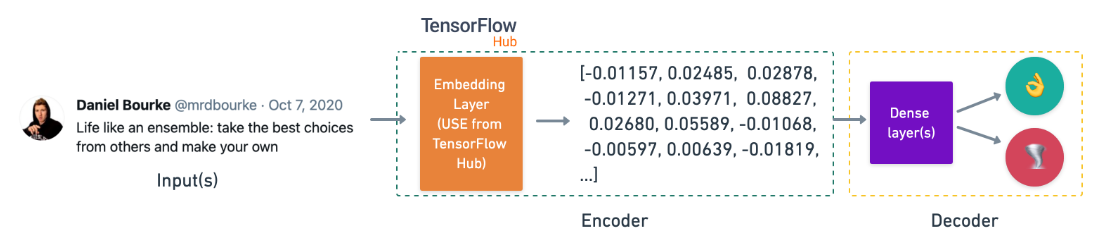

We can load in a TensorFlow Hub module using the hub.load() method and passing it the target URL of the module we'd like to use, in our case, it's "https://tfhub.dev/google/universal-sentence-encoder/4".

Let's load the Universal Sentence Encoder model and test it on a couple of sentences.

In [77]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [78]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])


Passing our sentences to the Universal Sentence Encoder (USE) encodes them from strings to 512 dimensional vectors, which make no sense to us but hopefully make sense to our machine learning models.

Speaking of models, let's build one with the USE as our embedding layer.

We can convert the TensorFlow Hub USE module into a Keras layer using the hub.KerasLayer class.

In [79]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [80]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________



Notice the number of paramters in the USE layer, these are the pretrained weights its learned on various text sources (Wikipedia, web news, web question-answer forums, etc, see the Universal Sentence Encoder paper for more).

The trainable parameters are only in our output layers, in other words, we're keeping the USE weights frozen and using it as a feature-extractor. We could fine-tune these weights by setting trainable=True when creating the hub.KerasLayer instance.

Now we've got a feature extractor model ready, let's train it and track its results to TensorBoard using our create_tensorboard_callback() function.

In [81]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20221227-015049
Epoch 1/5
215/215 [==============================] - 8s 22ms/step - loss: 0.5008 - accuracy: 0.7892 - val_loss: 0.4478 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4144 - accuracy: 0.8133 - val_loss: 0.4369 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3998 - accuracy: 0.8212 - val_loss: 0.4329 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3925 - accuracy: 0.8266 - val_loss: 0.4288 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3860 - accuracy: 0.8276 - val_loss: 0.4309 - val_accuracy: 0.8123


In [82]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.14443193],
       [0.72715044],
       [0.9856655 ],
       [0.19740927],
       [0.73417026],
       [0.6859662 ],
       [0.9808888 ],
       [0.97411025],
       [0.9157322 ],
       [0.08070082]], dtype=float32)

In [83]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [84]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8148798668657973,
 'recall': 0.8123359580052494,
 'f1': 0.810686575717776}

In [85]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.23, Difference: 1.97
Baseline precision: 0.81, New precision: 0.81, Difference: 0.00
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.02


#### Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

One of the benefits of using transfer learning methods, such as, the pretrained embeddings within the USE is the ability to get great results on a small amount of data (the USE paper even mentions this in the abstract).

To put this to the test, we're going to make a small subset of the training data (10%), train a model and evaluate it.

In [ ]:
### NOTE: Making splits like this will lead to data leakage ###
### (some of the training examples in the validation set) ###

### WRONG WAY TO MAKE SPLITS (train_df_shuffled has already been split) ### 

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [86]:
# One kind of correct way (there are more) to make data subset
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)


In [87]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [88]:
# Check the number of targets in our subset of data 
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64


To make sure we're making an appropriate comparison between our model's ability to learn from the full training set and 10% subset, we'll clone our USE model (model_6) using the **tf.keras.models.clone_model()** method.

In [89]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [90]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20221227-015304
Epoch 1/5
22/22 [==============================] - 3s 42ms/step - loss: 0.6716 - accuracy: 0.6574 - val_loss: 0.6526 - val_accuracy: 0.6903
Epoch 2/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5972 - accuracy: 0.8032 - val_loss: 0.5944 - val_accuracy: 0.7362
Epoch 3/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5178 - accuracy: 0.8149 - val_loss: 0.5398 - val_accuracy: 0.7625
Epoch 4/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4526 - accuracy: 0.8265 - val_loss: 0.5084 - val_accuracy: 0.7677
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4094 - accuracy: 0.8382 - val_loss: 0.4915 - val_accuracy: 0.7703


In [91]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.24043238],
       [0.76837856],
       [0.90137184],
       [0.29067948],
       [0.57149994],
       [0.83565134],
       [0.8062943 ],
       [0.83358175],
       [0.8554568 ],
       [0.11749922]], dtype=float32)

In [92]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [93]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.03412073490814,
 'precision': 0.7755630249535594,
 'recall': 0.7703412073490814,
 'f1': 0.7667059443150692}

In [94]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New precision: 0.78, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


### Comparing the performance of each of our models

But just before we do, it's worthwhile mentioning, this type of practice is a standard deep learning workflow. Training various different models, then comparing them to see which one performed best and continuing to train it if necessary.

The important thing to note is that for all of our modelling experiments we used the same training data (except for model_7 where we used 10% of the training data).

In [95]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.740157,0.791492,0.787402,0.784697
lstm,75.065617,0.751008,0.750656,0.748927
gru,76.771654,0.767545,0.767717,0.766793
bidirectional,76.640420,0.766590,0.766404,0.765121
conv1d,77.821522,0.780752,0.778215,0.775881
tf_hub_sentence_encoder,81.233596,0.814880,0.812336,0.810687
tf_hub_10_percent_data,77.034121,0.775563,0.770341,0.766706


In [96]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

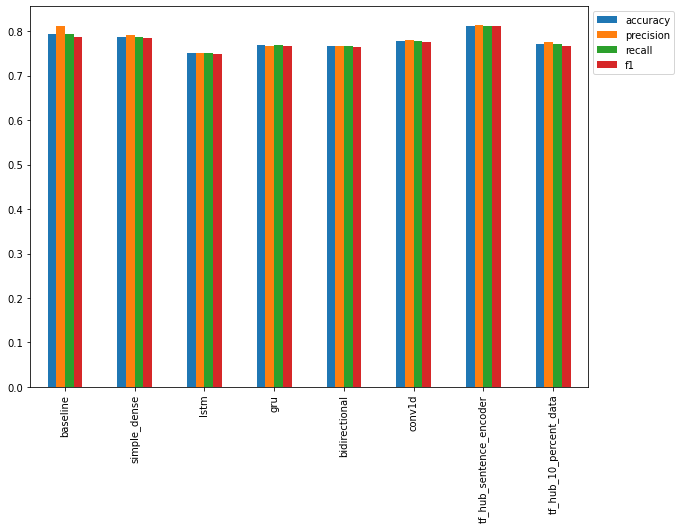

In [97]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

Looks like our pretrained USE TensorFlow Hub models have the best performance, even the one with only 10% of the training data seems to outperform the other models. This goes to show the power of transfer learning.

How about we drill down and get the F1-score's of each model?

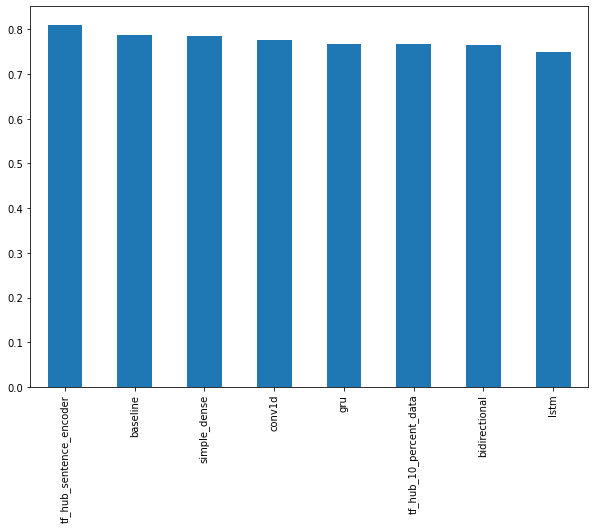

In [98]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [ ]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs \
#   --name "NLP modelling experiments" \
#   --description "A series of different NLP modellings experiments with various models" \
#   --one_shot # exits the uploader when upload has finished

In [ ]:
# If you need to remove previous experiments, you can do so using the following command
# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

### Combining our models (model ensembling/stacking)

Many production systems use an ensemble (multiple different models combined) of models to make a prediction.

The idea behind model stacking is that if several uncorrelated models agree on a prediction, then the prediction must be more robust than a prediction made by a singular model.

The keyword in the sentence above is uncorrelated, which is another way of saying, different types of models. For example, in our case, we might combine our baseline, our bidirectional model and our TensorFlow Hub USE model.

Although these models are all trained on the same data, they all have a different way of finding patterns.

If we were to use three similarly trained models, such as three LSTM models, the predictions they output will likely be very similar.

Think of it as trying to decide where to eat with your friends. If you all have similar tastes, you'll probably all pick the same restaurant. But if you've all got different tastes and still end up picking the same restaurant, the restaurant must be good.

Since we're working with a classification problem, there are a few of ways we can combine our models:

1. Averaging - Take the output prediction probabilities of each model for each sample, combine them and then average them.
2. Majority vote (mode) - Make class predictions with each of your models on all samples, the predicted class is the one in majority. For example, if three different models predict [1, 0, 1] respectively, the majority class is 1, therefore, that would be the predicted label.
3. Model stacking - Take the outputs of each of your chosen models and use them as inputs to another model.

Again, the concept of model stacking is best seen in action.

We're going to combine our baseline model (model_0), LSTM model (model_2) and our USE model trained on the full training data (model_6) by averaging the combined prediction probabilities of each.

In [99]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [100]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 78.08398950131233,
 'precision': 0.7805216999297674,
 'recall': 0.7808398950131233,
 'f1': 0.7805169025578647}

In [101]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [102]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

In [103]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.787402,0.791492,0.787402,0.784697
lstm,0.750656,0.751008,0.750656,0.748927
gru,0.767717,0.767545,0.767717,0.766793
bidirectional,0.766404,0.766590,0.766404,0.765121
conv1d,0.778215,0.780752,0.778215,0.775881
tf_hub_sentence_encoder,0.812336,0.814880,0.812336,0.810687
tf_hub_10_percent_data,0.770341,0.775563,0.770341,0.766706
ensemble_results,0.780840,0.780522,0.780840,0.780517


### Saving and loading a trained model

There are two main ways of saving a model in TensorFlow:

1. The HDF5 format.
2. The SavedModel format (default).

In [104]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")


If you save a model as a HDF5, when loading it back in, you need to let TensorFlow know about any custom objects you've used (e.g. components which aren't built from pure TensorFlow, such as TensorFlow Hub components).

In [105]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [106]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4309 - accuracy: 0.8123


[0.43088313937187195, 0.8123359680175781]

Calling the save() method on our target model and passing it a filepath allows us to save our model in the SavedModel format.

In [107]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")


If you use SavedModel format (default), you can reload your model without specifying custom objects using the tensorflow.keras.models.load_model() function.

In [108]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [109]:
# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4309 - accuracy: 0.8123


[0.43088313937187195, 0.8123359680175781]

For most use cases, the SavedModel format will suffice. However, this is a TensorFlow specific standard. If you need a more general-purpose data standard, HDF5 might be better. For more, check out the TensorFlow documentation on saving and loading models.

### Finding the most wrong examples

One of the best ways to inspect your data is to sort your model's predictions and find the samples it got most wrong, meaning, what predictions had a high prediction probability but turned out to be wrong.

Once again, visualization is your friend. Visualize, visualize, visualize.

To make things visual, let's take our best performing model's prediction probabilities and classes along with the validation samples (text and ground truth labels) and combine them in a pandas DataFrame.

1. If our best model still isn't perfect, what examples is it getting wrong?
2. Which ones are the most wrong?
3. Are there some labels which are wrong? E.g. the model gets it right but the ground truth label doesn't reflect this

In [110]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.144432
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.727150
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.985666
3,@camilacabello97 Internally and externally scr...,1,0.0,0.197409
4,Radiation emergency #preparedness starts with ...,1,1.0,0.734170


In [111]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910481
759,FedEx will no longer transport bioterror patho...,0,1.0,0.864676
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.837961
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.836362
628,@noah_anyname That's where the concentration c...,0,1.0,0.835225
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.834875
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.800890
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.782611
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.782433
144,The Sound of Arson,0,1.0,0.771343


In [112]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9104807376861572
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8646755218505859
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8379610776901245
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1, Prob: 0.8363615274429321
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.8352250456809998
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8348746299743652
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Pr


We can view the bottom end of our most_wrong DataFrame to inspect false negatives (model predicts 0, not a real diaster Tweet, when it should've predicted 1, real diaster Tweet).

In [113]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06304335594177246
Text:
@BoyInAHorsemask its a panda trapped in a dogs body

----

Target: 1, Pred: 0, Prob: 0.06279505789279938
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0, Prob: 0.060608115047216415
Text:
VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNEhVvOHVK

----

Target: 1, Pred: 0, Prob: 0.0573178268969059
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.04535556212067604
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.041451405733823776
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.03926115110516548
Text:
@SoonerMagic_ I mean I'm a fan but 


Do you notice anything interesting about the most wrong samples?

Are the ground truth labels correct? What do you think would happen if we went back and corrected the labels which aren't?

### Making predictions on the test dataset
Alright we've seen how our model's perform on the validation set.

But how about the test dataset?

We don't have labels for the test dataset so we're going to have to make some predictions and inspect them for ourselves.

Let's write some code to make predictions on random samples from the test dataset and visualize them.

In [114]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 38ms/step
Pred: 0, Prob: 0.2784994840621948
Text:
just collecting the rubble

----

1/1 [==============================] - 0s 37ms/step
Pred: 1, Prob: 0.8458979725837708
Text:
Florida Firefighters Rescue Scared Meowing Kitten from Vent Shaft http://t.co/RVKffcxbvC #fire #firefighter

----

1/1 [==============================] - 0s 36ms/step
Pred: 0, Prob: 0.09774228185415268
Text:
@fplhints hazard depay ozil Ritchie .
Should I go with 3 crazy strikers or 4 midfielders ? #fplboss

----

1/1 [==============================] - 0s 32ms/step
Pred: 0, Prob: 0.4784316420555115
Text:
LIVE on #Periscope: Wild Wing Epicentre https://t.co/U2fUK072F9

----

1/1 [==============================] - 0s 32ms/step
Pred: 0, Prob: 0.05953933298587799
Text:
I'm falling to pieces and I won't be whole until you let me in ? Heroine by Sleeping With Sirens ÛÓ https://t.co/tQxLQUKq7z

----

1/1 [==============================] - 0s 29ms/step
Pred: 1, Prob: 0.5749700069

### Predicting on Tweets from the wild

How about we find some Tweets and use our model to predict whether or not they're about a diaster or not?

To start, let's take one of my own Tweets on living life like an ensemble model.

In [115]:
# Turn Tweet into string
daniels_tweet = "Life like an ensemble: take the best choices from others and make your own"

In [116]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [117]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=daniels_tweet)

1/1 [==============================] - 0s 34ms/step
Pred: 0.0 (not real disaster) Prob: 0.04623395949602127
Text:
Life like an ensemble: take the best choices from others and make your own


In [118]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [119]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_1)

1/1 [==============================] - 0s 31ms/step
Pred: 1.0 (real disaster) Prob: 0.9625465869903564
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [120]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_2)

1/1 [==============================] - 0s 31ms/step
Pred: 1.0 (real disaster) Prob: 0.9678557515144348
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


### The speed/score tradeoff

In [121]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [122]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 10ms/step


(0.3035389269998632, 0.0003983450485562509)

In [123]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.035505760999967606, 4.659548687659791e-05)


It seems with our current hardware (in my case, I'm using a Google Colab notebook) our best performing model takes over 10x the time to make predictions as our baseline model.

Is that extra prediction time worth it?

Let's compare time per prediction versus our model's F1-scores.

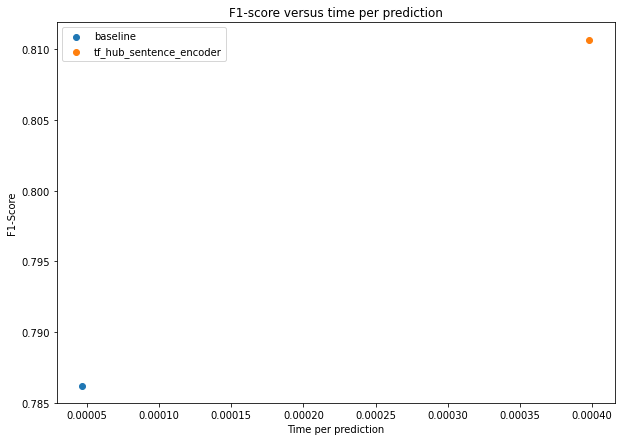

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");

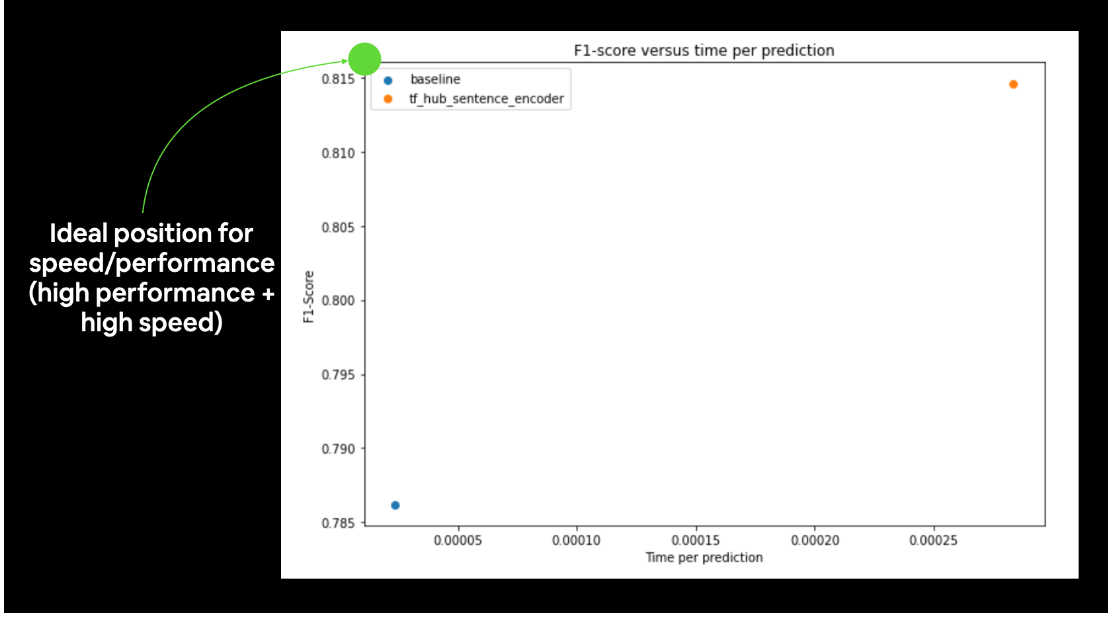